In [1]:
import numpy as np
import pandas as pd
import os
import re
from tqdm.notebook import tqdm, trange
from razdel import tokenize
from pymorphy2 import MorphAnalyzer

# Загрузка данных 

In [2]:
n_files = 0
for _dir in ['pos', 'neg', 'neu']:
    n_files += len(os.listdir(f'data\{_dir}'))

df = []
with tqdm(total = n_files) as psbar:
    for _dir in ['pos', 'neg', 'neu']:
        for file_name in os.listdir(f'data\{_dir}'):
            with open(f'data\{_dir}\{file_name}', 'r', encoding = 'UTF-8') as f:
                df.append((f.read(), _dir))
                psbar.update(1)
            
df = pd.DataFrame(df, columns = ['review', 'target'])

  0%|          | 0/131669 [00:00<?, ?it/s]

Это пригодится позже

In [3]:
df['target'] = df['target'].map({'neg': 0, 'neu': 1, 'pos': 2})
df['target'] = np.array(df['target'].values, dtype = np.int8)

In [4]:
import pickle
with open(r'additional_data\targets.npy', 'wb') as tr_file:
    np.save(tr_file, df['target'].values)

# Предобработка

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
s_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def token_is_good(token, stop_words = []):
    if len(token) < 4 or len(token) > 25:
        return False
    if token in stop_words:
        return False
    if re.fullmatch(r'[А-Яа-яЁёЙй]+', token) is None:
        return False
    # Если слово содержит в себе три одинаковых символа подряд
    if re.match(r'^.*(.)(\1)(\1).*$', token) is not None:
        return False
    return True

Теперь разобьём каждый отзыв на слова

In [7]:
morph = MorphAnalyzer()
tokenized_reviews = []
for i in trange(len(df)):
    tokenized_reviews.append([morph.parse(tok.text)[0].normal_form for tok in tokenize(df.loc[i, 'review']) if token_is_good(tok.text, s_words)])
    # Эквивалентно:
    # review = df.loc[i, 'review']
    # review = [morph.parse(tok.text)[0].normal_form for tok in tokenize(review) if token_is_good(tok.text, s_words)]
    # tokenized_reviews.append(review)
    # Дело в том, что так, как это реализовано получается быстрее примерно на 10-15 минут

  0%|          | 0/131669 [00:00<?, ?it/s]

In [8]:
import smart_open
from gensim.models import Word2Vec

EMBEDDING_LEN = 200

w2v_model = Word2Vec(min_count = 25,
                     window = 7,
                     vector_size = EMBEDDING_LEN,
                     negative = 10,
                     alpha = 0.05,
                     min_alpha = 0.0005,
                     sample = 1e-4,
                     sg = 1,
                     hs = 1,
                     seed = 42)

w2v_model.build_vocab(tokenized_reviews)
w2v_model.train(tokenized_reviews, total_examples = w2v_model.corpus_count, epochs = 10, report_delay = 120)

(187084764, 269076800)

Сохраним модель и длину векторного представления слов 

In [17]:
w2v_model.save(r'additional_data\word2vec.model')

In [18]:
with open(r'additional_data\embedding_len.pickle', 'wb') as file:
    pickle.dump(EMBEDDING_LEN, file)

И, наконец, удалим из полученных отзывов редкие слова

In [19]:
for i in trange(len(tokenized_reviews)):
    tokenized_reviews[i] = [x for x in tokenized_reviews[i] if x in w2v_model.wv]

  0%|          | 0/131669 [00:00<?, ?it/s]

Дабы выбрать оптимальную длину (в словах), до которой будут обрезаться или дополняться нулями отзывы, взглянем на распределение их длин 

  0%|          | 0/131669 [00:00<?, ?it/s]

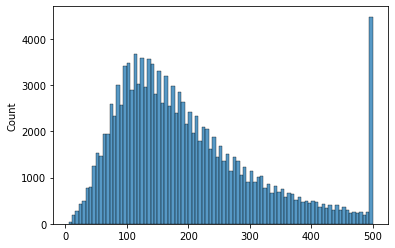

In [31]:
import seaborn as sns
_lens = []

for rev in tqdm(tokenized_reviews):
    _lens.append(len(rev))
    
sns.histplot(_lens);

# Важно
```
То, что выше является результатом моей криворукости - я случайно запустил эту ячейку после того, как все отзывы дополнил (обрезал) до длины 500 и теперь, чтоб заново получить исходный график надо запустить блокнот заново, что займёт примерно 3 часа. Как только мой ноутбук будет иметь свободное время (в обозримом будущем он будет перебирать нейросетевые архитектуры), блокнот я обязательно перезапущу.

Распределение длин до 500 отражено верно - нули в соответствующих отзывах я обрезал. В остальном, дальше гистограмма продолжает планомерное падение и практически сходит на нет в районе 600-700. Так же имеются крайне редкие выбросы в виде отзывов на более чем 800 слов
```

Кажется, порядка 500 слов должно быть достаточно

In [32]:
MAX_LEN = 500

for i in trange(len(tokenized_reviews)):
    _len = len(tokenized_reviews[i])
    if _len < MAX_LEN:
        tokenized_reviews[i] = ['0'] * (MAX_LEN - _len) + tokenized_reviews[i]
    else:
        # Если отзыв длинее пятиста слов, берём последние 500, ибо из житейского опыта
        # кажется, что если отзыв достаточно длинный, то отношение автора к картине 
        # раскрывается ближе к концу
        tokenized_reviews[i] = tokenized_reviews[i][-MAX_LEN:]

  0%|          | 0/131669 [00:00<?, ?it/s]

In [36]:
with open(r'additional_data\tokenized_reviews.pickle', 'wb') as tr_file, \
     open(r'additional_data\max_len.pickle', 'wb') as ml_file:
    pickle.dump(tokenized_reviews, tr_file)
    pickle.dump(MAX_LEN, ml_file)